# Part 03 - Modeling

### 01 - Import library

In [21]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import librosa
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
%load_ext tensorboard
!rm -rf ./logs/ # remove previous tensorboard logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 02 - Unpickle the features

In [22]:
df_tr = pd.read_pickle('../pickles/train.pkl')
df_ts = pd.read_pickle('../pickles/test.pkl')
df_ho = pd.read_pickle('../pickles/hold_out.pkl')

### 03 - Transform into tensorflow-friendly format

In [23]:
# use label encoder to convert the language labels to numeric target column
encoder = LabelEncoder()
encoder.fit(df_tr['lang'])
labels = encoder.classes_
y_tr = encoder.transform(df_tr['lang'])
y_ts = encoder.transform(df_ts['lang'])
y_ho = encoder.transform(df_ho['lang'])
print(labels)

['cn' 'tw']


In [24]:
# Convert feature matrix into a keras-friendly format
X_tr = np.array(df_tr['features'].tolist())
X_tr = X_tr.reshape(X_tr.shape[0],128,256,1)
X_ts = np.array(df_ts['features'].tolist())
X_ts = X_ts.reshape(X_ts.shape[0],128,256,1)
X_ho = np.array(df_ho['features'].tolist())
X_ho = X_ho.reshape(X_ho.shape[0],128,256,1)

In [25]:
# Check the shape
print(X_tr.shape)
print(y_tr.shape)
print(X_ts.shape)
print(y_ts.shape)
print(X_ho.shape)
print(y_ho.shape)

(5924, 128, 256, 1)
(5924,)
(740, 128, 256, 1)
(740,)
(740, 128, 256, 1)
(740,)


### 04 - CNN Model

start with the base model

In [26]:
# Base model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(128, 256, 1), padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(64, (5, 5), activation='relu', padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(128, (5, 5), activation='relu', padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [27]:
tf.keras.losses.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
EPOCHS = 100
checkpoint_filepath = '../temp_checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

# Define the Keras TensorBoard callback.
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model.
history = model.fit(X_tr, y_tr, epochs=EPOCHS, validation_data=(X_ts, y_ts), callbacks=[tensorboard_callback, model_checkpoint_callback])

Train on 5924 samples, validate on 740 samples
Epoch 1/100
5924/5924 [==============================] - 5s 791us/sample - loss: 0.4194 - accuracy: 0.8027 - val_loss: 0.4205 - val_accuracy: 0.8230
Epoch 2/100
5924/5924 [==============================] - 5s 794us/sample - loss: 0.3889 - accuracy: 0.8217 - val_loss: 0.3898 - val_accuracy: 0.8135
Epoch 3/100
5924/5924 [==============================] - 5s 783us/sample - loss: 0.3655 - accuracy: 0.8356 - val_loss: 0.4203 - val_accuracy: 0.8189
Epoch 4/100
5924/5924 [==============================] - 5s 783us/sample - loss: 0.3613 - accuracy: 0.8439 - val_loss: 0.3602 - val_accuracy: 0.8365
Epoch 5/100
5924/5924 [==============================] - 5s 783us/sample - loss: 0.3287 - accuracy: 0.8536 - val_loss: 0.3674 - val_accuracy: 0.8297
Epoch 6/100
5924/5924 [==============================] - 5s 782us/sample - loss: 0.3151 - accuracy: 0.8607 - val_loss: 0.3444 - val_accuracy: 0.8473
Epoch 7/100
5924/5924 [==============================] - 5s

In [32]:
# Show tensorboard
# %tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 3430), started 1:42:40 ago. (Use '!kill 3430' to kill it.)

In [33]:
checkpoint_filepath = '../temp_checkpoint/'
model.load_weights(checkpoint_filepath)
val_loss, val_acc = model.evaluate(X_ho, y_ho, verbose=1)

740/740 [==============================] - 0s 329us/sample - loss: 0.7491 - accuracy: 0.8919


then build the best model

In [121]:
# Best model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(128, 256, 1), padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (5, 5), activation='relu', padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (5, 5), activation='relu', padding = 'same'))
model.add(MaxPooling2D((3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.summary()

In [117]:
tf.keras.losses.SparseCategoricalCrossentropy(name='sparse_categorical_crossentropy')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [118]:
EPOCHS = 100
checkpoint_filepath = '../temp_checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
history = model.fit(X_tr, y_tr, epochs=EPOCHS, validation_data=(X_ts, y_ts), callbacks=[model_checkpoint_callback])

In [ ]:
checkpoint_filepath = '../temp_checkpoint/'
model.load_weights(checkpoint_filepath)
val_loss, val_acc = model.evaluate(X_ho, y_ho, verbose=1)

save the model

In [ ]:
# model.save('../saved_model/20200604/')

### 05 - Load the best model

In [34]:
new_model = tf.keras.models.load_model('../saved_model/20200604')

In [35]:
new_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 256, 32)      832       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 42, 85, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 42, 85, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 42, 85, 64)        51264     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 28, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 28, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 28, 128)      

In [36]:
val_loss, val_acc = new_model.evaluate(X_ho, y_ho, verbose=1)

740/740 [==============================] - 0s 444us/sample - loss: 0.2762 - accuracy: 0.9135


### 06 - Tensorboard

In [10]:
# Define the Keras TensorBoard callback.
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model.
EPOCHS = 100
history = new_model.fit(X_tr, y_tr, epochs=EPOCHS, validation_data=(X_ts, y_ts), callbacks=[tensorboard_callback])

Train on 5924 samples, validate on 740 samples
Epoch 1/100
5924/5924 [==============================] - 5s 822us/sample - loss: 0.0795 - accuracy: 0.9715 - val_loss: 0.3719 - val_accuracy: 0.8905
Epoch 2/100
5924/5924 [==============================] - 5s 811us/sample - loss: 0.0712 - accuracy: 0.9745 - val_loss: 0.3535 - val_accuracy: 0.8905
Epoch 3/100
5924/5924 [==============================] - 5s 810us/sample - loss: 0.1230 - accuracy: 0.9576 - val_loss: 0.3424 - val_accuracy: 0.8851
Epoch 4/100
5924/5924 [==============================] - 5s 811us/sample - loss: 0.0902 - accuracy: 0.9700 - val_loss: 0.4651 - val_accuracy: 0.8919
Epoch 5/100
5924/5924 [==============================] - 5s 812us/sample - loss: 0.0804 - accuracy: 0.9713 - val_loss: 0.3881 - val_accuracy: 0.8878
Epoch 6/100
5924/5924 [==============================] - 5s 813us/sample - loss: 0.0700 - accuracy: 0.9735 - val_loss: 0.3876 - val_accuracy: 0.8892
Epoch 7/100
5924/5924 [==============================] - 5s

In [9]:
# %tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 3430), started 0:04:06 ago. (Use '!kill 3430' to kill it.)

### 07 - Confusion Matrix

In [40]:
labels = ['Mainland China', 'Taiwan']
y_pred = new_model.predict(X_ho)
y_preds = np.argmax(y_pred, axis = 1)
cm = confusion_matrix(y_ho, y_preds)
print(cm)

[[347  23]
 [ 41 329]]


[Text(0, 0.5, 'Mainland China'), Text(0, 1.5, 'Taiwan')]

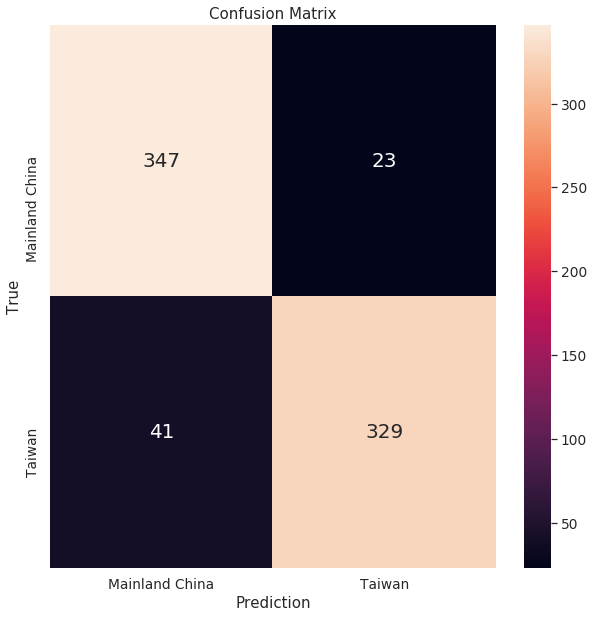

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, ax = ax, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Prediction')
ax.set_ylabel('True')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
# plt.savefig('img/confuse.png')